In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel, linearized_power_law
sns.set_style('white')
def calc_pct(pred_best, pred_worst, pred_curr):
    return (pred_worst - pred_curr)/(pred_worst - pred_best)

dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
gl_expmt = '5_False_0.1_0.4_uniform_29000_30_1_290001_5800_0_0.5_0.5_0_0.8'
ml_expmt = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
mltiny_expmt = '5_False_0.1_0.4_uniform_21000_5250_0_30_1_213973_0.5_0.5_0_0.85'
gltiny_expmt = '5_False_0.1_0.4_uniform_9400_30_1_94000_1880_0_0.5_0.5_0_0.8'
expmts = [('gl', gl_expmt), ('gl-tiny', gltiny_expmt), ('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt)]
expmts = [('ml-20m-tiny', mltiny_expmt)]


In [77]:
for dataset_name, expmt in expmts:
    results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    all_test_mses = np.loadtxt(results_path + 'test_mses')
    all_macro_mses = np.load(results_path + 'macro_mses.npy')

    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_observable = data['n_observable'].iloc[0]
    results = []
    user_results = []
    n_runs = 5
    pcts_available = []

    for j in range(n_runs):
        worst_mse = data[data['run'] == j]['worst_mse'].iloc[0]
        best_mse = data[data['run'] == j]['best_mse'].iloc[0]
        ss = all_ss[j]
        mses = all_mses[j]
        test_mses = all_test_mses[j]
        macro_mses = all_macro_mses[j]
        n_pts = len(np.where(ss) > n_init)
        for i, (size, mse) in enumerate(zip(ss, mses)):
            if size < n_init:
                continue
            # this method fits a beginning power law curve and an end one
            pct_available = (size-n_init)/(n_observable-n_init)
            pcts_available.append(pct_available)
            true_pct = (worst_mse - mse)/(worst_mse - best_mse)
            start_cm = NLLS_rse(linearized_power_law)
            start = 0
            end = np.min([9, i+1])
            end = int(i/2)
            start_cm.fit(ss[start:end], mses[start:end])

            end_cm = NLLS_rse(linearized_power_law)
            start = int(i/2)
            end_cm.fit(ss[start:i+1], mses[start:i+1])

            pred_worst = start_cm.f(n_init, **start_cm.p)
            pred_best = end_cm.f(n_observable, **end_cm.p)
            pred_curr = end_cm.f(size, **end_cm.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_mix', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})
            
            n_users = macro_mses.shape[1]
            for k in range(n_users):
                user_macro_mses = macro_mses[:,k]
                start_cm = NLLS_rse(linearized_power_law)
                start = 0
                end = np.min([9, i+1])
                end = int(i/2)
                start_cm.fit(ss[start:end], user_macro_mses[start:end])

                end_cm = NLLS_rse(linearized_power_law)
                start = int(i/2)
                end_cm.fit(ss[start:i+1], user_macro_mses[start:i+1])
                pred_worst = start_cm.f(n_init, **start_cm.p)
                pred_best = end_cm.f(n_observable, **end_cm.p)
                pred_curr = end_cm.f(size, **end_cm.p)
                pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
                true_pct = calc_pct(user_macro_mses[i], user_macro_mses[5], 
                                    user_macro_mses[-1])
                user_results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 
                                     'pred_curr': pred_curr, 'cm': 'NLS_mix',
                                     'pred_pct': pred_pct, 'pct_available': pct_available,
                                     'run': j, 'user': k, 'true_best': user_macro_mses[-1],
                                     'true_worst': user_macro_mses[5],
                                     'true_pct': true_pct})
                user_results.append({'pred_best': user_macro_mses[-1], 
                                     'pred_worst': user_macro_mses[5], 
                                     'pred_curr': user_macro_mses[i], 'cm': 'True',
                                     'pred_pct': true_pct, 'true_best': user_macro_mses[-1],
                                     'true_worst': user_macro_mses[5],
                                     'true_pct': true_pct, 'pct_available': pct_available,
                                     'run': j, 'user': k})
                

    pd.DataFrame(results).to_csv('../results/forecasting/' + dataset_name + '/pred_performance')
    pd.DataFrame(user_results).to_csv('../results/forecasting/' + dataset_name + '/user_pred_performance')

/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full ran

In [5]:
all_results = pd.DataFrame(results)

In [43]:
g = .8


5000
5000
5000
5000


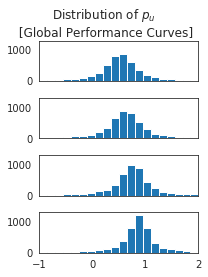

In [163]:
fig, axs = plt.subplots(4, 1, figsize=(3, 4), sharey=True, sharex=True)
g_opts = [.6, .7, .8, .9]
n_users = all_macro_mses.shape[2]
for j, g in enumerate(g_opts):
    gg = all_results[all_results['pred_pct'] > g]
    gg = gg.sort_values('pred_pct').groupby(['cm', 'run']).first().reset_index()
    pct_collected =  np.around(gg['pct_available'], 4).iloc[0]
    stop_idx = np.min(np.where(np.around(pcts_available, 4) == pct_collected)[0])
    user_pcts = []
    for k in range(5):
        for i in range(n_users):
            worst_mse = all_macro_mses[k,5,i]
            best_mse = all_macro_mses[k,-1,i]
            curr_mse = all_macro_mses[k,stop_idx,i]
            user_pcts.append((worst_mse - curr_mse)/(worst_mse - best_mse))
    user_pcts = np.array(user_pcts)
    print(len(user_pcts))
    ax = axs[j]
    ax.hist(user_pcts, range=(-1, 2), bins=20)
    #ax.set_title("g = " + str(g))
    ax.set_xlim(-1, 2)
    ax.set_ylim(0, 1300)
    #ax.set_ylabel("# of Users")
    ax.set_xlabel("")
    if j != 0:
        ax.set_ylabel("")
#fig.text(0.5, 0.03, r"$p_u$", ha='center')
plt.suptitle(r"Distribution of $p_u$" + " \n [Global Performance Curves]")
plt.tight_layout(rect=[0, 0.03, 1, 0.90])


In [149]:
dataset_name = 'ml-20m-tiny'
user_results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/user_pred_performance')
expmt = '5_False_0.1_0.4_uniform_21000_5250_0_30_1_213973_0.5_0.5_0_0.85'
results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
all_macro_mses = np.load(results_path + 'macro_mses.npy')
all_ss = np.loadtxt(results_path + 'sample_sizes')


5000
5000
5000
5000


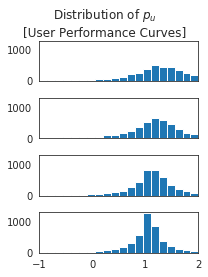

In [162]:
fig, axs = plt.subplots(4, 1, figsize=(3, 4), sharey=True, sharex=True)
g_opts = [.6, .7, .8, .9]
user_sets = []
for i, g in enumerate(g_opts):
    ax = axs[i]
    user_results_df = pd.DataFrame(user_results)
    gg = user_results_df[user_results_df['pred_pct'] > g]
    gg = gg[gg['cm'] == 'NLS_mix']
    gg_run = gg.sort_values('pred_pct').groupby(['run', 'user']).first().reset_index()
    
    #gg_run = gg[(gg['true_pct'] > 0) &  (gg['true_pct'] <= 1)]
    #gg_run = gg_run[gg_run['user'].isin(users)]
    #user_sets.append(set(gg_run['user']))
    print(len(gg_run))
    ax.hist(gg_run['true_pct'], range=(-1, 2), bins=20)
    #ax.set_title("g = " + str(g))
    ax.set_xlim(-1,2 )
    ax.set_ylim(0, 1300)
    #ax.set_ylabel("# of Users")
    ax.set_xlabel("")
    if j != 0:
        ax.set_ylabel("")
#fig.text(0.5, 0.03, '$p_u$', ha='center')
fig.suptitle(r"Distribution of $p_u$" + "\n[User Performance Curves]")
plt.tight_layout(rect=[0, 0.03, 1, 0.90])


In [114]:
users = list(set.intersection(*user_sets))

In [ ]:
# 20% of users have a worse per-user MSE given all data than at the beginning

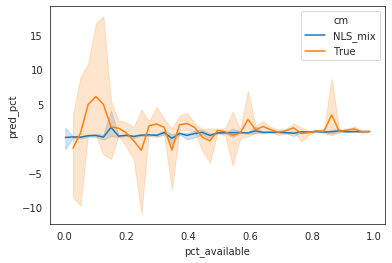

In [31]:
sns.lineplot(x='pct_available', y='pred_pct', hue='cm', 
             data=user_results_df[user_results_df['run'] == 0])


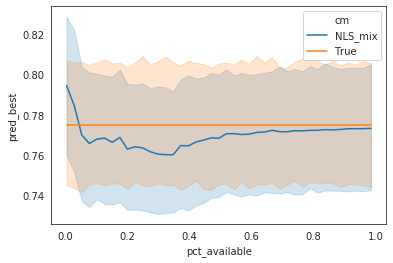

In [33]:
sns.lineplot(x='pct_available', y='pred_best', hue='cm', 
             data=user_results_df[user_results_df['run'] == 0])


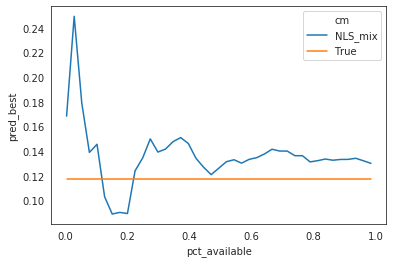

In [40]:
gg = user_results_df[user_results_df['user'] == 10]
gg = gg[gg['run'] == 2]
sns.lineplot(x='pct_available', y='pred_best', hue='cm', 
             data=gg)


In [15]:
# Plot the distribution of user curves for a given macro_mse curve
m_mse_df = []
for i in range(5):
    for j in range(1000):
        for k in range(46):
            mse = all_macro_mses[i, k, j]
            m_mse_df.append({'run': i, 'user': j, 'ss': all_ss[i][k], 'mse': mse})
m_mse_df = pd.DataFrame(m_mse_df)

Text(0.5, 1.0, 'User MSEs over Data Collection')

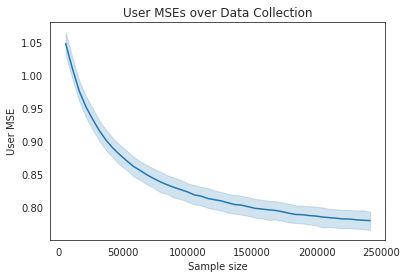

In [25]:
sns.lineplot(x='ss', y='mse', data=m_mse_df)
plt.xlabel("Sample size")
plt.ylabel("User MSE")
plt.title("User MSEs over Data Collection")

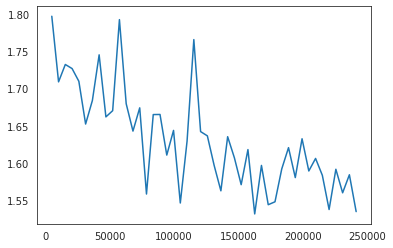

In [30]:
plt.plot(all_ss[0], all_macro_mses[0,:,20])

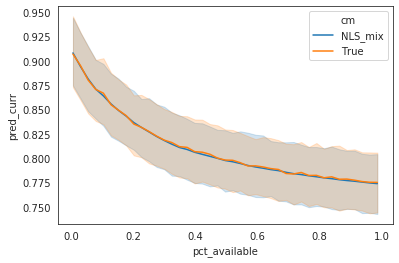

In [9]:
# can report errors over runs, or over users...over users is a much larger spread.
#one_user = user_results_df[user_results_df['user'] == 1]
first_run = user_results_df[user_results_df['run'] == 0]
# Plot evolution of best performance prediction
sns.lineplot(x='pct_available', y='pred_curr', hue='cm', data=first_run)

In [10]:
# plot evolution of % performance prediction (focus on one run, show variance across users)
all_macro_mses.shape

NameError: name 'all_macro_mses' is not defined

NameError: name 'user_mses' is not defined

In [ ]:
f